#  Importing Necessary Packages

In [1]:
import pandas as pd
import numpy as np
# For plotting graphs
import seaborn as sns
import matplotlib.pyplot as plt
# To standardise the data and k-Means Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. Reading the data from csv

In [2]:
data = pd.read_excel(r"C:\Users\Dell\Downloads\Online Retail.xlsx")

# 2. Understand the Data

In [3]:
# Displaying the top 5 rows of the dataset using head()
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
# Display statistical summary of the dataset
print(data.describe())

            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303  


In [6]:
# Displaying number of unique values
data.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [7]:
# Checking the datatype of each column
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [8]:
# Checking the shape of the dataset that has been loaded
data.shape

(541909, 8)

# 3. Clean the data

In [9]:
# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Fill missing CustomerID values based on InvoiceDate
data['CustomerID'] = data.groupby('InvoiceDate')['CustomerID'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else -1))


# Fill missing Description with a placeholder

data['Description'] = data.groupby('InvoiceNo')['Description'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'No Description'))


data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

C:\Users\Dell\AppData\Local\Temp\ipykernel_9128\388324466.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Description'] = data.groupby('InvoiceNo')['Description'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'No Description'))


In [10]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [11]:
# drop duplicates
data = data.drop_duplicates()

In [12]:
### Handle Outliers in the dataset

In [13]:
# Calculate TotalSpend
data['TotalSpend'] = data['Quantity'] * data['UnitPrice']

# Aggregate data to customer level
customer_data = data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalSpend': 'sum',
      # Frequency
    'InvoiceNo': 'nunique',
    # For Recency
    'InvoiceDate': 'max'  
}).reset_index()

# Calculate Frequency and Recency
customer_data.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)
customer_data['Recency'] = (data['InvoiceDate'].max() - customer_data['InvoiceDate']).dt.days

# Drop unnecessary columns
customer_data = customer_data[['CustomerID', 'Quantity', 'TotalSpend', 'Frequency', 'Recency']]

# Inspect the resulting dataframe
customer_data

,CustomerID,Quantity,TotalSpend,Frequency,Recency
0,-1.0,251587,1342813.57,3294,0
1,12346.0,0,0.00,2,325
2,12347.0,2458,4310.00,7,1
3,12348.0,2341,1797.24,4,74
4,12349.0,631,1757.55,1,18
...,...,...,...,...,...
4368,18280.0,45,180.60,1,277
4369,18281.0,54,80.82,1,180
4370,18282.0,98,176.60,3,7
4371,18283.0,1357,2045.53,16,3


In [14]:
def identify_and_remove_outliers(dataset, feature_columns):
    """
    Identifies and removes outliers from the specified columns of the dataset.

    Parameters:
    dataset (DataFrame): The input data.
    feature_columns (list): List of columns to check for outliers.

    Returns:
    DataFrame: The dataset with outliers removed.
    """
    outlier_indices = set()
    
    for feature in feature_columns:
        Q1 = dataset[feature].quantile(0.25)
        Q3 = dataset[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        
        # Identify outliers for the current feature
        feature_outliers = dataset[(dataset[feature] < lower_limit) | (dataset[feature] > upper_limit)].index
        outlier_indices.update(feature_outliers)
    
    # Remove identified outliers from the dataset
    cleaned_dataset = dataset.drop(outlier_indices)
    
    return cleaned_dataset

# Apply the function to the customer data
cleaned_customer_data = identify_and_remove_outliers(customer_data, ['Quantity', 'TotalSpend', 'Frequency', 'Recency'])

print(f"Original dataset size: {customer_data.shape[0]}")
print(f"Dataset size after removing outliers: {cleaned_customer_data.shape[0]}")

cleaned_customer_data


Original dataset size: 4373
Dataset size after removing outliers: 3663


,CustomerID,Quantity,TotalSpend,Frequency,Recency
1,12346.0,0,0.00,2,325
4,12349.0,631,1757.55,1,18
5,12350.0,197,334.40,1,309
6,12352.0,470,1545.41,11,35
7,12353.0,20,89.00,1,203
...,...,...,...,...,...
4367,18278.0,66,173.90,1,73
4368,18280.0,45,180.60,1,277
4369,18281.0,54,80.82,1,180
4370,18282.0,98,176.60,3,7


#  4. Transform the Data

In [15]:
# Normalize the data
scaler = StandardScaler()
scaled_columns = scaler.fit_transform(cleaned_customer_data[['Quantity', 'TotalSpend', 'Frequency', 'Recency']])

# Convert the scaled features back to a DataFrame
scaled_customer_data = pd.DataFrame(scaled_columns, columns=['Quantity', 'TotalSpend', 'Frequency', 'Recency'])
scaled_customer_data

,Quantity,TotalSpend,Frequency,Recency
0,-1.033639,-1.082133,-0.477305,2.586083
1,0.317000,1.233102,-0.860718,-0.798631
2,-0.611966,-0.641625,-0.860718,2.409681
3,-0.027616,0.953648,2.973419,-0.611204
4,-0.990830,-0.964893,-0.860718,1.241018
...,...,...,...,...
3658,-0.892368,-0.853053,-0.860718,-0.192249
3659,-0.937318,-0.844227,-0.860718,2.056877
3660,-0.918054,-0.975668,-0.860718,0.987440
3661,-0.823873,-0.849496,-0.093891,-0.919907


# 5. K Means Clustering

### 1. Use the elbow graph to identify the optimal number of clusters

In [16]:
wcss=[]
for i in range(1,10):
    km = KMeans(n_clusters=i)
    km.fit(customer_data)
    wcss.append(km.inertia_)

In [17]:
wcss

[2268403416097.47,
 407849617350.7554,
 159440216849.22858,
 94954206555.46704,
 66171558822.27966,
 48827815816.94872,
 43782701573.48284,
 38984491518.11466,
 23986189140.738564]

## Plotting the elbow graph

<Axes: >

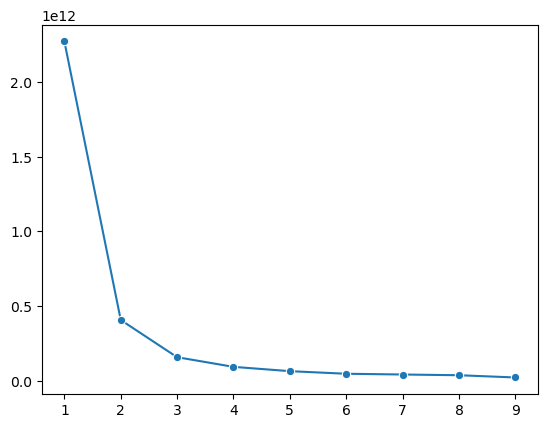

In [19]:
sns.lineplot(x=range(1,10), y=wcss, marker='o')

### Based on the elbow plot, determine the optimal number of clusters
### Let's assume the optimal number of clusters is 5


In [20]:
# Applying K-means clustering
optimal_clusters = 5 
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cleaned_customer_data['Cluster'] = kmeans.fit_predict(scaled_customer_data)

# Visualise the Clusters using Scatterplot

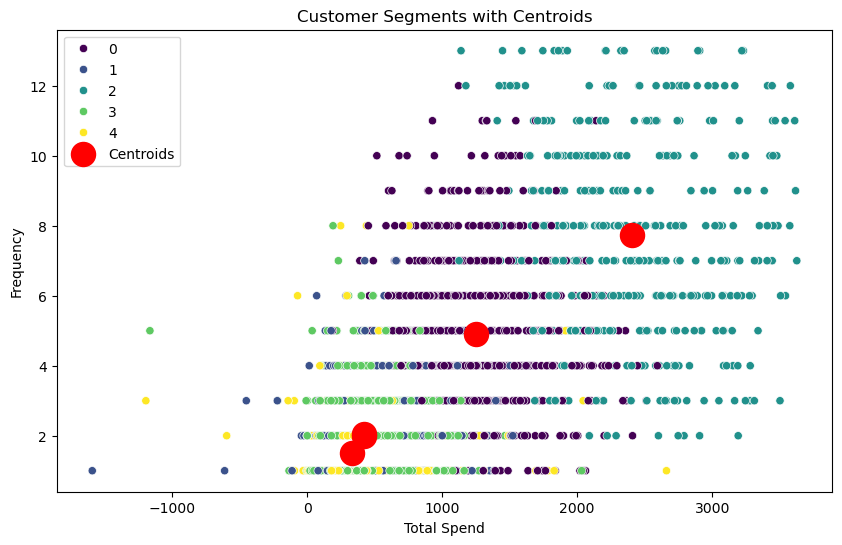

In [24]:
# Visualize the centroids of each cluster
centroids = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids)  # Inverse tr ansform to get the original scale

plt.figure(figsize=(10, 6))
sns.scatterplot(x=cleaned_customer_data['TotalSpend'], y=cleaned_customer_data['Frequency'], hue=cleaned_customer_data['Cluster'], palette='viridis')
plt.scatter(centroids[:, 1], centroids[:, 2], s=300, c='red', label='Centroids')
plt.xlabel('Total Spend')
plt.ylabel('Frequency')
plt.title('Customer Segments with Centroids')
plt.legend()
plt.show()

# Assign Cluster Labels to the Original Data

In [26]:
# Merge the cluster labels with the original dataset
original_data_clusters = data.merge(cleaned_customer_data[['CustomerID', 'Cluster']], on='CustomerID', how='left')
original_data_clusters.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSpend,Cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,NaN
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,NaN


# Analyze Each Segment

In [27]:
"""
    Calculates summary statistics for each cluster.

    Parameters:
    data (DataFrame): The input data containing cluster labels.
    cluster_column (str): The column name for cluster labels. Default is 'Cluster'.
    columns_to_aggregate (list): List of columns to calculate statistics for. If None, default columns are used.

    Returns:
    DataFrame: The summary statistics for each cluster.
"""

cluster_summary = cleaned_customer_data.groupby('Cluster').agg({
    'Quantity': ['mean', 'median', 'std'],
    'TotalSpend': ['mean', 'median', 'std'],
    'Frequency': ['mean', 'median', 'std'],
    'Recency': ['mean', 'median', 'std']
}).reset_index()

cluster_summary
    


Cluster     Quantity                       TotalSpend                        \
                  mean  median         std         mean    median         std   
0       0   750.217284   735.5  294.912716  1251.681149  1214.230  403.577290   
1       1   243.261649   194.5  192.777869   421.242491   346.865  320.028654   
2       2  1436.085106  1416.0  365.019596  2408.604069  2358.840  564.054905   
3       3   243.385355   218.0  161.261836   420.541658   379.120  255.531752   
4       4   171.025000   126.0  168.234380   332.170981   259.045  319.350476   

  Frequency                      Recency                    
       mean median       std        mean median        std  
0  4.909877    5.0  2.030795   43.655556   28.0  43.458388  
1  2.044803    2.0  1.193850  157.197133  157.0  33.216506  
2  7.737589    8.0  2.829211   36.226950   21.0  44.395951  
3  2.002959    2.0  1.107804   39.200444   35.0  26.398286  
4  1.513462    1.0  1.000872  268.984615  266.0  33.716656

# Profile the Customer Segments

Customer Segment Cluster 4 Profile:
Mean Quantity: 171.025
Mean Total Spend: 332.17098076923077
Mean Frequency: 1.5134615384615384
Mean Recency: 268.9846153846154
################################################################################
Customer Segment Cluster 0 Profile:
Mean Quantity: 750.2172839506172
Mean Total Spend: 1251.681149382716
Mean Frequency: 4.909876543209877
Mean Recency: 43.65555555555556
################################################################################
Customer Segment Cluster 2 Profile:
Mean Quantity: 1436.0851063829787
Mean Total Spend: 2408.6040685579196
Mean Frequency: 7.73758865248227
Mean Recency: 36.226950354609926
################################################################################
Customer Segment Cluster 3 Profile:
Mean Quantity: 243.3853550295858
Mean Total Spend: 420.5416582840237
Mean Frequency: 2.002958579881657
Mean Recency: 39.20044378698225
###############################################################################

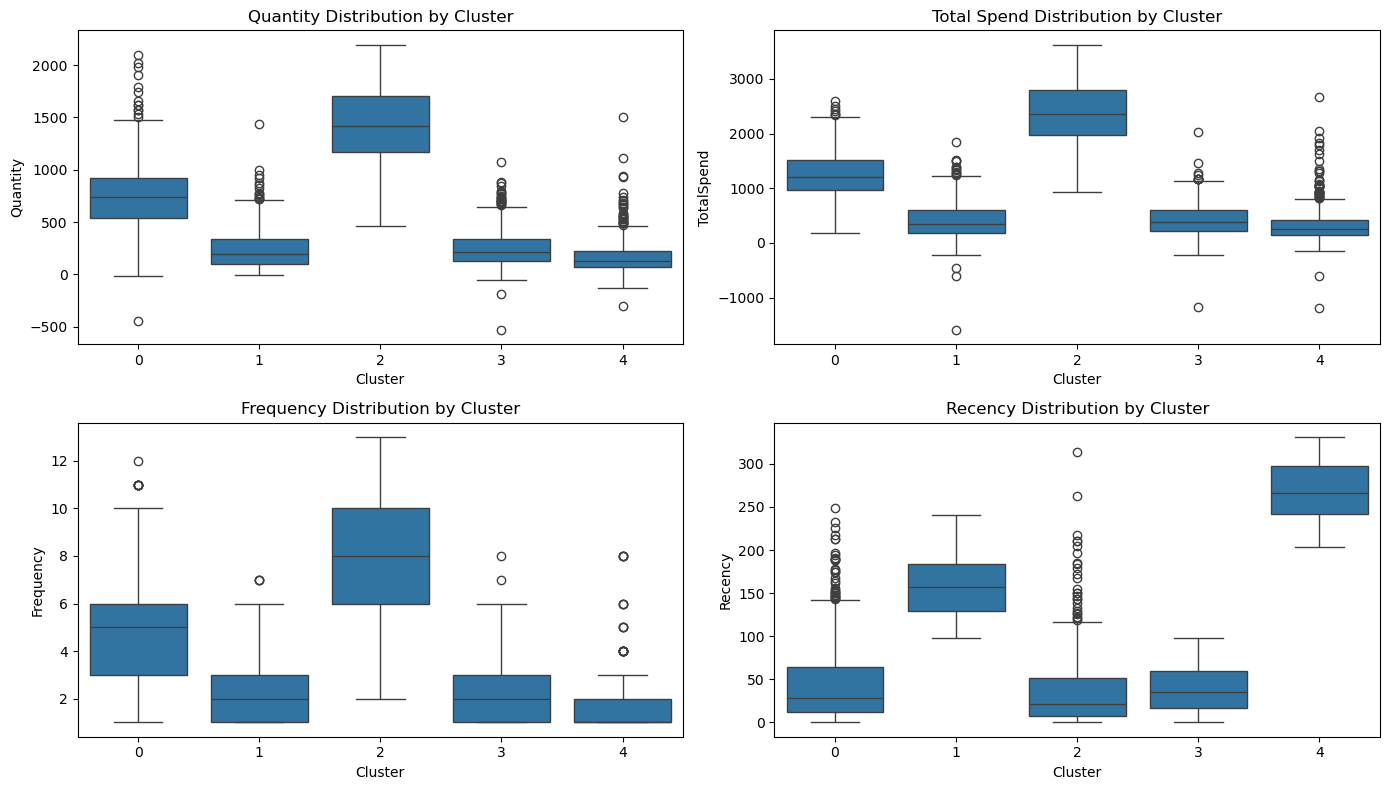

In [28]:
# Profile each customer segment
for cluster in cleaned_customer_data['Cluster'].unique():
    cluster_data = cleaned_customer_data[cleaned_customer_data['Cluster'] == cluster]
    print(f"Customer Segment Cluster {cluster} Profile:")
    print(f"Mean Quantity: {cluster_data['Quantity'].mean()}")
    print(f"Mean Total Spend: {cluster_data['TotalSpend'].mean()}")
    print(f"Mean Frequency: {cluster_data['Frequency'].mean()}")
    print(f"Mean Recency: {cluster_data['Recency'].mean()}")
    print("################################################################################")

# Visualization using box plots
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
sns.boxplot(x='Cluster', y='Quantity', data=cleaned_customer_data)
plt.title('Quantity Distribution by Cluster')

plt.subplot(2, 2, 2)
sns.boxplot(x='Cluster', y='TotalSpend', data=cleaned_customer_data)
plt.title('Total Spend Distribution by Cluster')

plt.subplot(2, 2, 3)
sns.boxplot(x='Cluster', y='Frequency', data=cleaned_customer_data)
plt.title('Frequency Distribution by Cluster')

plt.subplot(2, 2, 4)
sns.boxplot(x='Cluster', y='Recency', data=cleaned_customer_data)
plt.title('Recency Distribution by Cluster')

plt.tight_layout()
plt.show()